In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import matplotlib
tab10 = matplotlib.cm.get_cmap('tab10')

In [2]:
WT_MHC = 'GPHSMRYFETAVSRPGLEEPRYISVGYVDNKEFVRFDSDAENPRYEPRAPWMEQEGPEYWERETQKAKGQ'+\
         'EQWFRVSLRNLLGYYNQSAGGSHTLQQMSGCDLGSDWRLLRGYLQFAYEGRDYIALNEDLKTWTAADMAA'+\
         'QITRRKWEQSGAAEHYKAYLEGECVEWLHRYLKNGNATL'

In [3]:
metrics = pd.read_csv('<path/to/your>/ppi_scores.sc',sep='\s+',skiprows=1) #the score file you set in ./score_only.flags
metrics['delta_sap_target'] = metrics['presap_score'] - metrics['postsap_score']
metrics['description'] = metrics['description'].map(lambda x: '_'.join(x.split('_')[:-1]))

metrics['design_seq'] = metrics['sequence'].map(lambda x: x[:-len(WT_MHC)])
metrics['MHC_seq'] = metrics['sequence'].map(lambda x: x[-len(WT_MHC):])

150
150


In [4]:
pssm_metrics.loc[0:5,'description']

0    HHH_b1_06420_000000070_nat_0001_000130_0.8_0001
1    HHH_b1_06420_000000070_nat_0001_000130_0.8_0002
2    HHH_b1_06420_000000070_nat_0001_000130_0.8_0003
3    HHH_b1_06420_000000070_nat_0001_000130_0.8_0004
4    HHH_b1_06420_000000070_nat_0001_000130_0.8_0005
5    HHH_b1_06420_000000070_nat_0001_000135_0.5_0001
Name: description, dtype: object

In [5]:
metrics.loc[0:5,'description']

0    HHH_b1_06420_000000070_nat_0001_000120_0.2_0001
1    HHH_b1_06420_000000070_nat_0001_000120_0.2_0002
2    HHH_b1_06420_000000070_nat_0001_000120_0.2_0003
3    HHH_b1_06420_000000070_nat_0001_000120_0.2_0004
4    HHH_b1_06420_000000070_nat_0001_000120_0.2_0005
5    HHH_b1_06420_000000070_nat_0001_000120_0.5_0001
Name: description, dtype: object

In [6]:
metrics.columns

Index(['SCORE:_x', 'total_score_x', 'buns_heavy_ball_1.1D',
       'contact_molec_sq5_apap_target', 'contact_molecular_surface',
       'contact_molecular_surface_apap_target', 'contact_patch', 'ddg',
       'ddg_hydrophobic', 'dslf_fa13', 'fa_atr', 'fa_atr_pocket', 'fa_dun_dev',
       'fa_dun_rot', 'fa_dun_semi', 'fa_elec', 'fa_intra_atr_xover4',
       'fa_intra_elec', 'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep',
       'fa_sol', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb',
       'hxl_tors', 'hydrophobic_residue_contacts', 'interface_buried_sasa',
       'interface_sc', 'interface_sc_int_area', 'interface_sc_median_dist',
       'lk_ball', 'lk_ball_bridge', 'lk_ball_bridge_uncpl', 'lk_ball_iso',
       'mismatch_probability', 'omega', 'p_aa_pp', 'postsap_score',
       'presap_score', 'pro_close', 'rama_prepro', 'ref',
       'sbuns5.0_heavy_ball_1.1D', 'score_per_res_x', 'ss_sc',
       'vbuns5.0_heavy_ball_1.1D', 'sequence', 'description',
       'delta_sap

In [7]:
metrics = metrics.sort_values(by='delta_sap_target',ascending=False).drop_duplicates(subset='MHC_seq',keep='first',
                                                                                    ignore_index=True)
print(len(metrics))

16


In [8]:
metrics = metrics[metrics['sequence'].map(lambda x: not x.endswith(WT_MHC))]
metrics.index = list(range(len(metrics)))
print(len(metrics))

16


In [9]:
metrics.loc[0,'sequence']

'DREDVERLLRSVEWAIKAGDPYSARILVELAREDAEKIGDERLRREVEELLRELEELGPHSMRYFEIAVSRPGLEEPRYISVGYVDNKEFVRFDSDAENPRYEPRAPWMEQEGPEYWERETQKAKGQEQWFRVSLRNLLGYYNQSAGGSHTLQQMSGCDLGPDWRLLRGYLQFAYEGRDYIALNEDLKTWTAADMAAQITRRKWEQSGAAEHYKAYLEGECVEWLHRYLKNGNATL'

In [10]:
#format:
#score_name: [cutoff, higher_better]
terms_and_cuts = {
    'ddg':                           [-61,  False], #recommended: -40 or 50%, whichever has more
    'ddg_hydrophobic':               [-15.6, False],
    'score_per_res_x' :                [-3.52, False], #recommended: no filter or -2.4
    'mismatch_probability':          [0.16,  False], #recommended: 0.1
    'contact_molecular_surface':     [500,   True], #recommended: 450
    #'contact_patch':                 [195,   True], #recommended: max out
    'contact_molec_sq5_apap_target': [3100,  True], #recommended: max out
    'delta_sap_target':              [9,  True], #recommended: max out
    #'delta_sap_binder':              [16,    True], #recommended: between 12 and 23 (but maxing out here)
    #'binder_blocked_sap':            [15.75,   False], #recommended: 15
    'hydrophobic_residue_contacts':  [6, True],
    'interface_buried_sasa':         [1705, True],
    'interface_sc':                  [0.64, True],
    'interface_sc_int_area':         [1140, True],
    'interface_sc_median_dist':      [0.6, False],
    'sbuns5.0_heavy_ball_1.1D':      [4, False],
    'vbuns5.0_heavy_ball_1.1D':      [4, False],
    'ss_sc':                         [0.776, True]
}

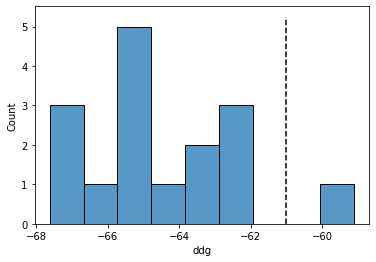

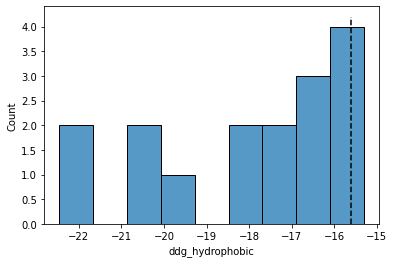

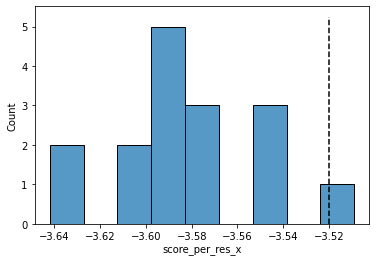

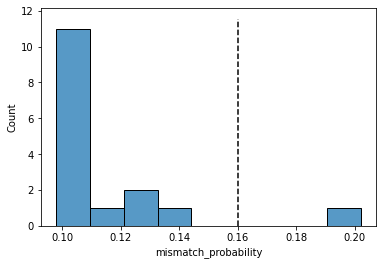

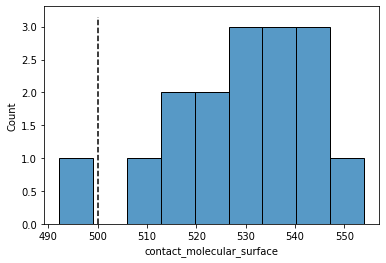

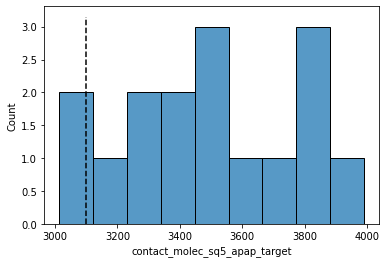

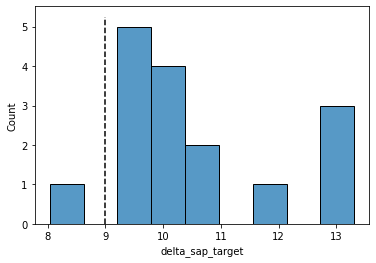

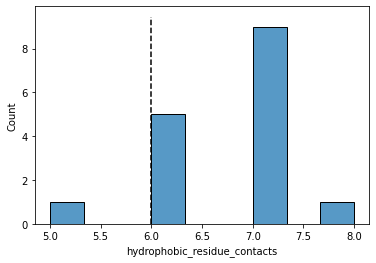

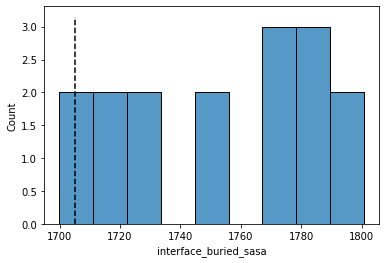

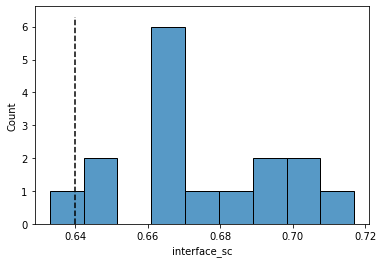

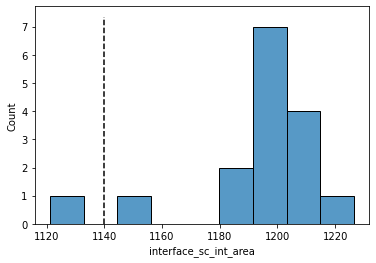

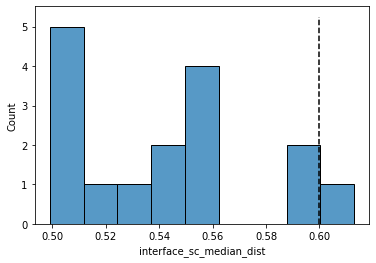

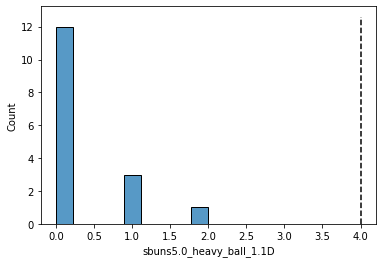

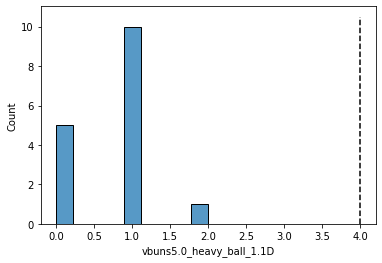

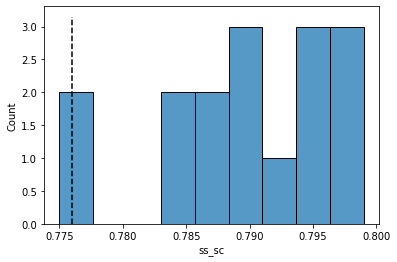

In [11]:
for term in terms_and_cuts:
    plt.figure()
    
    vals = metrics[term]
    vals = vals[~np.isnan(vals)]
    
    bins = np.linspace(np.min(vals),np.max(vals),10)
        
    sns.histplot(vals,bins=bins)
    plt.plot([terms_and_cuts[term][0]]*2,plt.ylim(),'k--')

In [12]:
filtered = metrics.copy()
filter_info = []
for term in terms_and_cuts:
    
    if terms_and_cuts[term][1]: #if higher better
        pass_rate = np.mean(metrics[term] >= terms_and_cuts[term][0])
        filtered = filtered[filtered[term] >= terms_and_cuts[term][0]]
    else: #lower better
        pass_rate = np.mean(metrics[term] <= terms_and_cuts[term][0])
        filtered = filtered[filtered[term] <= terms_and_cuts[term][0]]
        
    filter_info.append([term,terms_and_cuts[term][0],pass_rate])

with open('<desired/path/to>/filtered_designs.list','w') as f:
    for i,row in filtered.iterrows():
        f.write(row['description'] + '\n')
        
print('Pass rate: {}\tNum Passes: {}'.format(len(filtered)/len(metrics),len(filtered)))
filter_info = pd.DataFrame(filter_info,columns=['filter','cut','pass rate'])
filter_info

Pass rate: 0.75	Num Passes: 12


,filter,cut,pass rate
0,ddg,-61.000,0.9375
1,ddg_hydrophobic,-15.600,0.9375
2,score_per_res_x,-3.520,0.9375
3,mismatch_probability,0.160,0.9375
4,contact_molecular_surface,500.000,0.9375
5,contact_molec_sq5_apap_target,3100.000,0.9375
6,delta_sap_target,9.000,0.9375
7,hydrophobic_residue_contacts,6.000,0.9375
8,interface_buried_sasa,1705.000,0.9375
9,interface_sc,0.640,0.9375


In [13]:
filtered.index = list(range(len(filtered)))
filtered.loc[0,'sequence'][-len(WT_MHC):]

'GPHSMKYIEIAISRPGLEEPRYISVGYVDNKEFVRFDSDAENPRYEPRAPWMEQEGPEYWERETQKAKGQEQWFRVSLRNLLGYYNQSAGGSHTLQQMSGCDLGPDWRLLRGYLQFAYEGRDYIALNEDLKTWTAADMAAQITRRKWEQSGAAEHYKAYLEGECVEWLHRYLKNGNATL'

In [14]:
filtered['short_name'] = [f'hit6_CSM{i}' for i in range(len(filtered))]

filtered.to_csv('<desired/path/to>/filtered_designs_with_metrics.csv')

with open('<desired/path/to>/filtered_designs_MHC.fasta','w') as f:
    for i,row in filtered.iterrows():
        name = row['short_name']
        seq = row['MHC_seq']
        f.write(f'>{name}\n{seq}\n')